In [3]:
from IPython.utils import io
from joblib import Parallel, delayed

# default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.arff import loadarff      # to load the arff file from OpenML 

# pre-processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    label_binarize, 
    StandardScaler,
    MinMaxScaler,
)
from sklearn.model_selection import(
    train_test_split, 
    StratifiedKFold,
)

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.mlp import MLP                           # MLP implementado no Keras para utilização da GPU
from utils.encoder import Encoder
from utils.metrics import Metrics, Results          # Funções auxiliares para computar, plotar e salvar métricas

import warnings
warnings.filterwarnings('ignore')

Limitando o uso de VRAM

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## Definição de funções auxiliares

### Para K-Fold CV e GridSearch

In [5]:
def train_fold(model, X, y, train_index, test_index, grid=False):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    if type(model).__name__ == 'KerasClassifier':
        y_train = to_categorical(y_train, num_classes=10)
    else:
        y_train = y_train.values.ravel()

    with io.capture_output() as captured:   # para previnir o Tensorflow de poluir o output
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)

    accuracy, f1, conf_matrix, roc = Metrics(y_test, y_pred, y_score).compute()
    
    results = dict(acc=accuracy, f1=f1, cm=conf_matrix, roc=roc)

    if grid:
        results['gr'] = model.cv_results_
        print(model.best_params_)
    
    return results


def parallel_cv(model, X, y, kf, n_jobs=1, grid=False):
    out = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(train_fold)(
            model, X, y, train_idx, test_idx, grid=grid
        ) for train_idx, test_idx in kf.split(X, y)
    )
    return out


def get_metrics(out, grid=False):
    acc = [m['acc'] for m in out]
    f1 = [m['f1'] for m in out]
    cm = [m['cm'] for m in out]
    roc = [m['roc'] for m in out]

    if grid:
        gr = [m['gr'] for m in out]
        return acc, f1, cm, roc, gr

    return acc, f1, cm, roc

#### Do the experiment with the model

In [6]:
def experiment(filename, pipe, X, y, kf, n_jobs=1, plot=False):
    mdl_acc, mdl_f1, mdl_cm, mdl_roc = get_metrics(
        parallel_cv(pipe, X, y, kf, n_jobs)
    )
    
    mdl_results = Results(filename, mdl_acc, mdl_f1,
                          mdl_cm, mdl_roc, '')
    mdl_results.save()
    mdl_results.plot()

def make_preps(pipes:dict, X, y, kf, n_jobs=1):
    for filename, pipe in pipes.items():
        experiment(filename, pipe, X, y, kf, n_jobs)
        

### Visualização de instâncias do DS

In [7]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

# DataSet

### Carregando o DataSet

In [8]:
# loading data
raw_data = loadarff('mnist_784.arff')
mnist = pd.DataFrame(raw_data[0])

Devido à limitações de hardware, tomaremos uma amostra estratificada de tamanho n = 5000

In [9]:
df = mnist.groupby('class', group_keys=False).apply(
    lambda x: x.sample(500, random_state=1, ignore_index=True)
    ).sample(frac=1, ignore_index=True, random_state=1)

df.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093400,0.254400,0.145200,0.044000,0.053200,0.012400,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.179984,7.708772,4.904093,2.575848,3.464617,0.876812,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.000000,253.000000,252.000000,177.000000,244.000000,62.000000,0.0,0.0,0.0,0.0


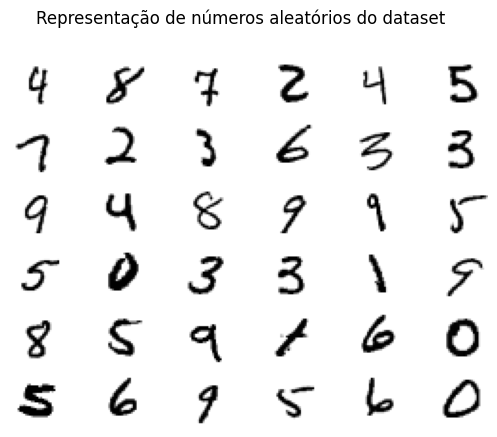

In [10]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(100, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                   dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


# Preprocessing


In [11]:
# treino e teste
X = df.iloc[:, 0:-1].values
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [16]:
fs = VarianceThreshold()

fs.fit_transform(X).shape[1]/784 * 100

83.92857142857143

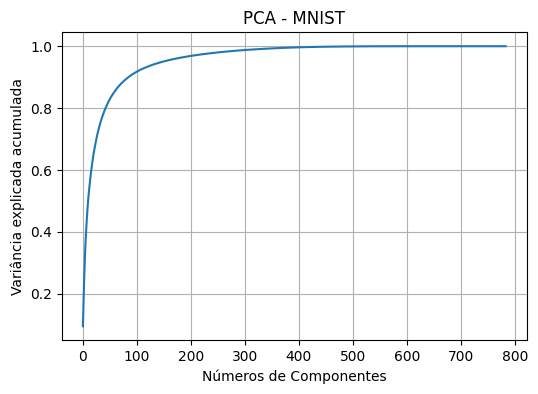

In [47]:
pca = PCA()
X_pca = pca.fit_transform(X)
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var)
# plt.axis('tight')
plt.grid()
plt.xlabel('Números de Componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('PCA - MNIST')
plt.show()

In [42]:
X_pca.shape[1] / 784

0.1096938775510204

# Experimentos

### Decision Tree

In [10]:
dt_pipes = {
    'dt': Pipeline([
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
    'dt_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
    'dt_pca': Pipeline([
        ('pca', PCA(0.9)),
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
    'dt_pca_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
    'dt_fs': Pipeline([
        ('fs', VarianceThreshold()),
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
    'dt_fs_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('fs', VarianceThreshold()),
        ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                            max_features=100, min_samples_split=10))
    ]),
}

dt_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('clf', DecisionTreeClassifier(criterion='entropy',max_depth=50,
                                        max_features=100, min_samples_split=10))
])

make_preps(dt_pipes, X_train, y_train, outer_cv, n_jobs=5)
experiment('dt_enc', dt_enc, X_train, y_train, outer_cv)

2022-09-23 16:01:22.255102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 16:01:22.256079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 16:01:22.256248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 16:01:22.256372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Resumo das métricas do modelo dt
Accurácia média (desvio): 0.748 (0.019)
F1-Score média (desvio): 0.748 (0.019)

Resumo das métricas do modelo dt_scaled
Accurácia média (desvio): 0.742 (0.029)
F1-Score média (desvio): 0.741 (0.029)

Resumo das métricas do modelo dt_pca
Accurácia média (desvio): 0.734 (0.024)
F1-Score média (desvio): 0.734 (0.023)

Resumo das métricas do modelo dt_pca_scaled
Accurácia média (desvio): 0.723 (0.028)
F1-Score média (desvio): 0.723 (0.028)

Resumo das métricas do modelo dt_fs
Accurácia média (desvio): 0.746 (0.028)
F1-Score média (desvio): 0.746 (0.028)

Resumo das métricas do modelo dt_fs_scaled
Accurácia média (desvio): 0.753 (0.028)
F1-Score média (desvio): 0.752 (0.029)



2022-09-23 16:01:35.026370: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Resumo das métricas do modelo dt_enc
Accurácia média (desvio): 0.603 (0.026)
F1-Score média (desvio): 0.601 (0.028)



### Naive Bayes

#### Gaussian NB

In [11]:
gnb_pipes = {
    'gnb': Pipeline([
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
    'gnb_pca': Pipeline([
        ('pca', PCA(0.8)),
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
    'gnb_fs': Pipeline([
        ('fs', VarianceThreshold()),
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
    'gnb_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
    'gnb_pca_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.9)),
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
    'gnb_fs_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', VarianceThreshold()),
        ('clf', GaussianNB(var_smoothing=0.1))
    ]),
}

gnb_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('clf', GaussianNB(var_smoothing=0.1))
])

experiment('gnb_enc', gnb_enc, X_train, y_train, outer_cv)
make_preps(gnb_pipes, X_train, y_train, outer_cv, n_jobs=5)


Resumo das métricas do modelo gnb_enc
Accurácia média (desvio): 0.804 (0.023)
F1-Score média (desvio): 0.803 (0.023)

Resumo das métricas do modelo gnb
Accurácia média (desvio): 0.811 (0.015)
F1-Score média (desvio): 0.811 (0.015)

Resumo das métricas do modelo gnb_pca
Accurácia média (desvio): 0.834 (0.016)
F1-Score média (desvio): 0.834 (0.016)

Resumo das métricas do modelo gnb_fs
Accurácia média (desvio): 0.811 (0.015)
F1-Score média (desvio): 0.811 (0.015)

Resumo das métricas do modelo gnb_scaled
Accurácia média (desvio): 0.680 (0.015)
F1-Score média (desvio): 0.671 (0.016)

Resumo das métricas do modelo gnb_pca_scaled
Accurácia média (desvio): 0.441 (0.035)
F1-Score média (desvio): 0.402 (0.040)

Resumo das métricas do modelo gnb_fs_scaled
Accurácia média (desvio): 0.680 (0.015)
F1-Score média (desvio): 0.671 (0.016)



#### Multinomial NB

In [12]:
mnb_pipes = {
    'mnb': Pipeline([
        ('clf', MultinomialNB(alpha=0.01))
    ]),
    'mnb_scaled': Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', MultinomialNB(alpha=0.01))
    ]),
    'mnb_fs': Pipeline([
        ('fs', VarianceThreshold()),
        ('clf', MultinomialNB(alpha=0.01))
    ]),
    'mnb_fs_scaled': Pipeline([
        ('scaler', MinMaxScaler()),
        ('fs', VarianceThreshold(0.1)),
        ('clf', MultinomialNB(alpha=0.01))
    ]),
    'mnb_pca_scaled': Pipeline([
        ('pca', PCA(0.95)),
        ('scaler', MinMaxScaler()),
        ('clf', MultinomialNB(alpha=0.01))
    ]),
}

mnb_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('scaler', MinMaxScaler()),
    ('clf', MultinomialNB(alpha=0.01))
])

make_preps(mnb_pipes, X_train, y_train, outer_cv, n_jobs=5)
experiment('mnb_enc', mnb_enc, X_train, y_train, outer_cv)

Resumo das métricas do modelo mnb
Accurácia média (desvio): 0.834 (0.016)
F1-Score média (desvio): 0.835 (0.015)

Resumo das métricas do modelo mnb_scaled
Accurácia média (desvio): 0.832 (0.015)
F1-Score média (desvio): 0.833 (0.014)

Resumo das métricas do modelo mnb_fs
Accurácia média (desvio): 0.834 (0.016)
F1-Score média (desvio): 0.835 (0.015)

Resumo das métricas do modelo mnb_fs_scaled
Accurácia média (desvio): 0.816 (0.024)
F1-Score média (desvio): 0.817 (0.024)

Resumo das métricas do modelo mnb_pca_scaled
Accurácia média (desvio): 0.854 (0.025)
F1-Score média (desvio): 0.854 (0.025)

Resumo das métricas do modelo mnb_enc
Accurácia média (desvio): 0.779 (0.026)
F1-Score média (desvio): 0.779 (0.027)



### KNN

In [16]:
knn_pipes = {
    'knn': Pipeline([
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),
    'knn_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),
    'knn_pca': Pipeline([
        ('pca', PCA(0.9)),
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),

    'knn_fs': Pipeline([
        ('fs', VarianceThreshold()),
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),

    'knn_pca_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.8)),
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),

    'knn_fs_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('fs', VarianceThreshold()),
        ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
    ]),

}

enc_arch =  [{'n_neurons': 784, 'activation': 'linear'},
             {'n_neurons': 48, 'activation': 'linear'}]

knn_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('clf', KNeighborsClassifier(n_neighbors=3,metric='euclidean', n_jobs=-1))
])

make_preps(knn_pipes, X_train, y_train, outer_cv, n_jobs=5)
experiment('knn_enc', knn_enc, X_train, y_train, outer_cv)


Resumo das métricas do modelo knn
Accurácia média (desvio): 0.929 (0.013)
F1-Score média (desvio): 0.929 (0.014)

Resumo das métricas do modelo knn_scaled
Accurácia média (desvio): 0.887 (0.016)
F1-Score média (desvio): 0.886 (0.016)

Resumo das métricas do modelo knn_pca
Accurácia média (desvio): 0.934 (0.016)
F1-Score média (desvio): 0.934 (0.016)

Resumo das métricas do modelo knn_fs
Accurácia média (desvio): 0.929 (0.013)
F1-Score média (desvio): 0.929 (0.014)

Resumo das métricas do modelo knn_pca_scaled
Accurácia média (desvio): 0.909 (0.012)
F1-Score média (desvio): 0.909 (0.012)

Resumo das métricas do modelo knn_fs_scaled
Accurácia média (desvio): 0.887 (0.016)
F1-Score média (desvio): 0.886 (0.016)

Resumo das métricas do modelo knn_enc
Accurácia média (desvio): 0.920 (0.014)
F1-Score média (desvio): 0.919 (0.015)



### SVC

In [14]:
svc_pipes = {
    'svc': Pipeline([
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
    'svc_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
    'svc_pca': Pipeline([
        ('pca', PCA(0.95)),
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
    'svc_pca_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(0.95)),
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
    'svc_fs': Pipeline([
        ('fs', VarianceThreshold()),
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
    'svc_fs_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('fs', VarianceThreshold()),
        ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
    ]),
}

svc_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('clf', SVC(C=10000, kernel='poly', degree=2, probability=True))
])

make_preps(svc_pipes, X_train, y_train, outer_cv, n_jobs=5)
experiment('svc_enc', svc_enc, X_train, y_train, outer_cv)


Resumo das métricas do modelo svc
Accurácia média (desvio): 0.947 (0.007)
F1-Score média (desvio): 0.947 (0.008)

Resumo das métricas do modelo svc_scaled
Accurácia média (desvio): 0.930 (0.011)
F1-Score média (desvio): 0.930 (0.011)

Resumo das métricas do modelo svc_pca
Accurácia média (desvio): 0.950 (0.007)
F1-Score média (desvio): 0.950 (0.007)

Resumo das métricas do modelo svc_pca_scaled
Accurácia média (desvio): 0.932 (0.009)
F1-Score média (desvio): 0.932 (0.009)

Resumo das métricas do modelo svc_fs
Accurácia média (desvio): 0.947 (0.007)
F1-Score média (desvio): 0.947 (0.008)

Resumo das métricas do modelo svc_fs_scaled
Accurácia média (desvio): 0.930 (0.011)
F1-Score média (desvio): 0.930 (0.011)

Resumo das métricas do modelo svc_enc
Accurácia média (desvio): 0.939 (0.010)
F1-Score média (desvio): 0.939 (0.010)



### MLP

In [15]:
mlp_pipes = {
    'mlp': Pipeline([
        ('clf', KerasClassifier(build_fn=MLP, n_classes=10, epochs=50, batch_size=256,
                                n_neurons=[1000,1000,1000], input_shape=(28*28,)))
    ]),
    'mlp_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KerasClassifier(build_fn=MLP, n_classes=10, epochs=50, batch_size=256,
                                n_neurons=[1000,1000,1000], input_shape=(28*28,)))
    ]),
    'mlp_pca': Pipeline([
        ('pca', PCA(148)),
        ('clf', KerasClassifier(build_fn=MLP, n_classes=10, epochs=50, batch_size=256,
                                n_neurons=[1000,1000,1000], input_shape=(148,)))
    ]),
    'mlp_pca_scaled': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(148)),
        ('clf', KerasClassifier(build_fn=MLP, n_classes=10, epochs=50, batch_size=256,
                                n_neurons=[1000,1000,1000], input_shape=(148,)))
    ]),
}

mlp_enc = Pipeline([
    ('enc', Encoder(784, 196)),
    ('clf', KerasClassifier(build_fn=MLP, n_classes=10, epochs=50, batch_size=256,
                            n_neurons=[1000,1000,1000], input_shape=(196,)))
])

make_preps(mlp_pipes, X_train, y_train, outer_cv)
experiment('mlp_enc', mlp_enc, X_train, y_train, outer_cv)


Resumo das métricas do modelo mlp
Accurácia média (desvio): 0.925 (0.013)
F1-Score média (desvio): 0.925 (0.014)

Resumo das métricas do modelo mlp_scaled
Accurácia média (desvio): 0.934 (0.013)
F1-Score média (desvio): 0.934 (0.014)

Resumo das métricas do modelo mlp_pca
Accurácia média (desvio): 0.921 (0.010)
F1-Score média (desvio): 0.921 (0.011)

Resumo das métricas do modelo mlp_pca_scaled
Accurácia média (desvio): 0.938 (0.008)
F1-Score média (desvio): 0.938 (0.008)

Resumo das métricas do modelo mlp_enc
Accurácia média (desvio): 0.915 (0.017)
F1-Score média (desvio): 0.915 (0.017)

